# hw3: Обучение без учителя

*Спасибо ещё одному великому курсу mlcourse.ai и авторам: Ольга Дайховская (@aiho в Slack ODS), Юрий Кашницкий (@yorko в Slack ODS).*

### О задании

В этом задании мы разберемся с тем, как работают методы снижения размерности и кластеризации данных. Заодно еще раз попрактикуемся в
задаче классификации.

Мы будем работать с набором данных [Samsung Human Activity Recognition](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones). Данные поступают с акселерометров и гироскопов мобильных телефонов Samsung Galaxy S3 (подробнее про признаки – по ссылке на UCI выше), также известен вид активности человека с телефоном в кармане – ходил ли он, стоял, лежал, сидел или шел вверх/вниз по лестнице.

Вначале мы представим, что вид активности нам неизвестнен, и попробуем кластеризовать людей чисто на основе имеющихся признаков. Затем решим задачу определения вида физической активности именно как задачу классификации.

**Заполните код в клетках (где написано "Ваш код здесь") и ответьте на вопросы, выделив ответ полужирным** (``` **выделить двойными звёздочками** ```).

### Оценивание и штрафы
Вам необходимо ответить на 10 вопросов и выполнить 2 задания. Каждое из заданий и вопросов имеет определенную «стоимость» (указана в скобках). Максимально допустимая оценка за работу — 10 баллов. Неэффективная и/или неоригинальная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Заполненный ноутбук ```hw3-unsupervised.ipynb``` необходимо загрузить на свой Github. Затем нужно оставить комментарий в Google-таблице с оценками в столбце "hw3" в строке со своей фамилией о том, что вы выполнили работу и оставить ссылку на ноутбук.

In [1]:
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
import os
os.environ['PYTHONWARNINGS'] = 'ignore'

import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm
from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering, KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.manifold import TSNE

RANDOM_STATE = 17
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.family'] = 'DejaVu Sans'

In [2]:
X_train = np.loadtxt("D:/Dataset_LW4/datasets/UCI HAR Dataset/train/X_train.txt")
y_train = np.loadtxt("D:/Dataset_LW4/datasets/UCI HAR Dataset/train/y_train.txt").astype(int)

X_test = np.loadtxt("D:/Dataset_LW4/datasets/UCI HAR Dataset/test/X_test.txt")
y_test = np.loadtxt("D:/Dataset_LW4/datasets/UCI HAR Dataset/test/y_test.txt").astype(int)

In [3]:
assert(X_train.shape == (7352, 561) and y_train.shape == (7352,))
assert(X_test.shape == (2947, 561) and y_test.shape == (2947,))

Для кластеризации нам не нужен вектор ответов, поэтому будем работать с объединением обучающей и тестовой выборок. Объедините *X_train* с *X_test*, а *y_train* – с *y_test*.

In [4]:
X = np.vstack([X_train, X_test])
y = np.hstack([y_train, y_test])
n_classes = np.unique(y).size

Определим число уникальных значений меток целевого класса.

In [5]:
np.unique(y)

array([1, 2, 3, 4, 5, 6])

In [6]:
n_classes = np.unique(y).size

[Эти метки соответствуют:](https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.names)
- 1 - ходьбе
- 2 - подъему вверх по лестнице
- 3 - спуску по лестнице
- 4 - сидению
- 5 - стоянию
- 6 - лежанию

*уж простите, если звучание этих существительных кажется корявым :)*

Отмасштабируйте выборку с помощью `StandardScaler` с параметрами по умолчанию.

In [7]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Понижаем размерность с помощью PCA, оставляя столько компонент, сколько нужно для того, чтобы объяснить как минимум 90% дисперсии исходных (отмасштабированных) данных. Используйте отмасштабированную выборку и зафиксируйте random_state (константа RANDOM_STATE).

In [8]:
pca = PCA(n_components=0.90, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_scaled)

Вопрос 1: (1 балл)

Какое минимальное число главных компонент нужно выделить, чтобы объяснить 90% дисперсии исходных (отмасштабированных) данных?

**Варианты:**
- 56
- **65**
- 66
- 193

In [9]:
n_components_pca = pca.n_components_
print(f"PCA: Сохранено компонент: {n_components_pca}")

PCA: Сохранено компонент: 65


**Вопрос 2:** (0.5 баллов)

Сколько процентов дисперсии приходится на первую главную компоненту? Округлите до целых процентов.

**Варианты:**
- 45
- **51**
- 56
- 61

In [10]:
print(f"PCA: Доля объясненной дисперсии первым компонентом: {round(pca.explained_variance_ratio_[0] * 100)}%")

PCA: Доля объясненной дисперсии первым компонентом: 51%


Визуализируйте данные в проекции на первые две главные компоненты.

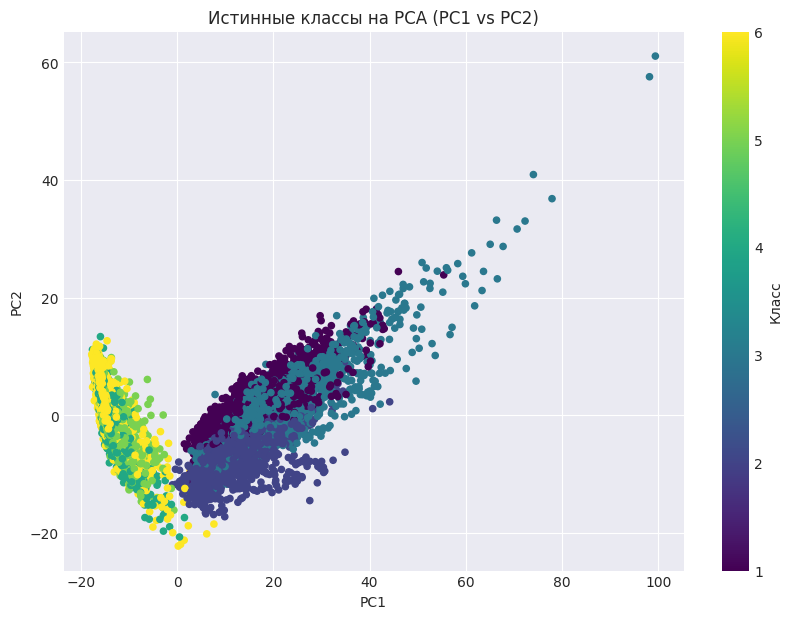

In [11]:
plt.figure(figsize=(10, 7))
plt.scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    c=y,
    s=20,
    cmap='viridis'
)
plt.title('Истинные классы на PCA (PC1 vs PC2)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar(label='Класс')
plt.show()

**Вопрос 3:** (0.5 баллов)

Если все получилось правильно, Вы увидите сколько-то кластеров, почти идеально отделенных друг от друга. Какие виды активности входят в эти кластеры?<br>

**Ответ:**
- 1 кластер: все 6 активностей
- **2 кластера: (ходьба, подъем вверх по лестнице, спуск по лестнице) и (сидение, стояние, лежание)**
- 3 кластера: (ходьба), (подъем вверх по лестнице, спуск по лестнице) и (сидение, стояние, лежание)
- 6 кластеров

**Задание 1.** (1 балл)

Сделайте кластеризацию данных методом `KMeans` (собственная имплементация и готовая реализация), обучив модель на данных со сниженной за счет PCA размерностью. В данном случае мы подскажем, что нужно искать именно 6 кластеров, но в общем случае мы не будем знать, сколько кластеров надо искать.

Параметры:

- **n_clusters** = n_classes (число уникальных меток целевого класса)
- **n_init** = 100
- **random_state** = RANDOM_STATE (для воспроизводимости результата)

Остальные параметры со значениями по умолчанию.

In [12]:
class CustomKMeans:
    def __init__(self, n_clusters=6, n_init=100, max_iter=300, tol=1e-4, random_state=None):
        self.n_clusters = n_clusters
        self.n_init = n_init
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = random_state
        self.cluster_centers_ = None
        self.labels_ = None
        self.inertia_ = None

    def _init_centroids(self, X, rng):
        idx = rng.choice(X.shape[0], self.n_clusters, replace=False)
        return X[idx].copy()

    def _assign_clusters(self, X, centroids):
        diff = X[:, None, :] - centroids[None, :, :]
        dist_sq = np.sum(diff * diff, axis=2)
        labels = np.argmin(dist_sq, axis=1)
        inertia = dist_sq[np.arange(X.shape[0]), labels].sum()
        return labels, inertia

    def _compute_centroids(self, X, labels, rng):
        n_samples, n_features = X.shape
        K = self.n_clusters
        counts = np.bincount(labels, minlength=K).astype(float)
        centroids = np.zeros((K, n_features), dtype=X.dtype)

        for j in range(n_features):
            sum_j = np.bincount(labels, weights=X[:, j], minlength=K)
            centroids[:, j] = sum_j

        non_empty = counts > 0
        centroids[non_empty] /= counts[non_empty, None]

        empty = ~non_empty
        if np.any(empty):
            centroids[empty] = X[rng.choice(n_samples, size=empty.sum(), replace=False)]
        return centroids

    def fit(self, X):
        X = np.asarray(X)
        best_inertia = None
        best_labels = None
        best_centroids = None
        rng_global = np.random.RandomState(self.random_state)
        tol_sq = self.tol ** 2

        for _ in range(self.n_init):
            rng = np.random.RandomState(rng_global.randint(0, 10**9))
            centroids = self._init_centroids(X, rng)

            for _ in range(self.max_iter):
                labels, inertia = self._assign_clusters(X, centroids)
                new_centroids = self._compute_centroids(X, labels, rng)
                shift_sq = np.sum((new_centroids - centroids) ** 2)
                centroids = new_centroids
                if shift_sq < tol_sq:
                    break

            if (best_inertia is None) or (inertia < best_inertia):
                best_inertia = inertia
                best_labels = labels.copy()
                best_centroids = centroids.copy()

        self.cluster_centers_ = best_centroids
        self.labels_ = best_labels
        self.inertia_ = best_inertia
        return self

    def fit_predict(self, X):
        self.fit(X)
        return self.labels_

custom_kmeans = CustomKMeans(
    n_clusters=n_classes,
    n_init=100,
    random_state=RANDOM_STATE
)
cluster_labels = custom_kmeans.fit_predict(X_pca)

Визуализируйте данные в проекции на первые две главные компоненты. Раскрасьте точки в соответствии с полученными метками кластеров.

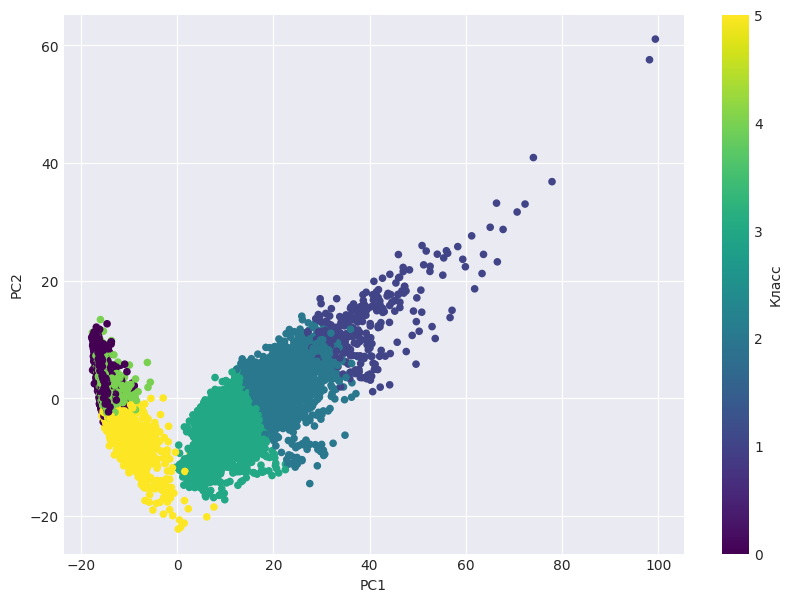

In [13]:
plt.figure(figsize=(10, 7))
plt.scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    c=cluster_labels,
    s=20,
    cmap='viridis'
)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar(label='Класс')
plt.show()

Посмотрите на соответствие между метками кластеров и исходными метками классов и на то, какие виды активностей алгоритм `KMeans` путает.

In [14]:
tab_kmeans = pd.crosstab(y, cluster_labels, margins=True)
tab_kmeans.index = ['ходьба', 'подъем вверх по лестнице', 'спуск по лестнице', 'сидение', 'стояние', 'лежание', 'все']
tab_kmeans.columns = [f'cluster{i + 1}' for i in range(n_classes)] + ['все']
print("\nТаблица соответствия истинных меток и кластеров K-Means:")
print(tab_kmeans)


Таблица соответствия истинных меток и кластеров K-Means:
                          cluster1  cluster2  cluster3  cluster4  cluster5  \
ходьба                           0        78       741       903         0   
подъем вверх по лестнице         0         5       296      1241         0   
спуск по лестнице                0       196       890       320         0   
сидение                         91         0         0         1      1235   
стояние                          0         0         0         0      1344   
лежание                       1558         0         0         5        52   
все                           1649       279      1927      2470      2631   

                          cluster6    все  
ходьба                           0   1722  
подъем вверх по лестнице         2   1544  
спуск по лестнице                0   1406  
сидение                        450   1777  
стояние                        562   1906  
лежание                        329   1944  
все      

Видим, что каждому классу (т.е. каждой активности) соответствуют несколько кластеров. Давайте посмотрим на максимальную долю объектов в классе, отнесенных к какому-то одному кластеру. Это будет простой метрикой, характеризующей, насколько легко класс отделяется от других при кластеризации.

Пример: если для класса "спуск по лестнице", в котором 1406 объектов,  распределение кластеров такое:
 - кластер 1 – 900
 - кластер 3 – 500
 - кластер 6 – 6,

то такая доля будет 900 / 1406 $\approx$ 0.64.


**Вопрос 4:** (1 балл)

Какой вид активности отделился от остальных лучше всего в терминах простой  метрики, описанной выше?<br>

**Ответ:**
- ходьба
- стояние
- спуск по лестнице
- **перечисленные варианты не подходят**

Видно, что kMeans не очень хорошо отличает только активности друг от друга. Используйте метод локтя, чтобы выбрать оптимальное количество кластеров. Параметры алгоритма и данные используем те же, что раньше, меняем только `n_clusters`.

Calculating Elbow: 100%|██████████| 6/6 [00:09<00:00,  1.60s/it]


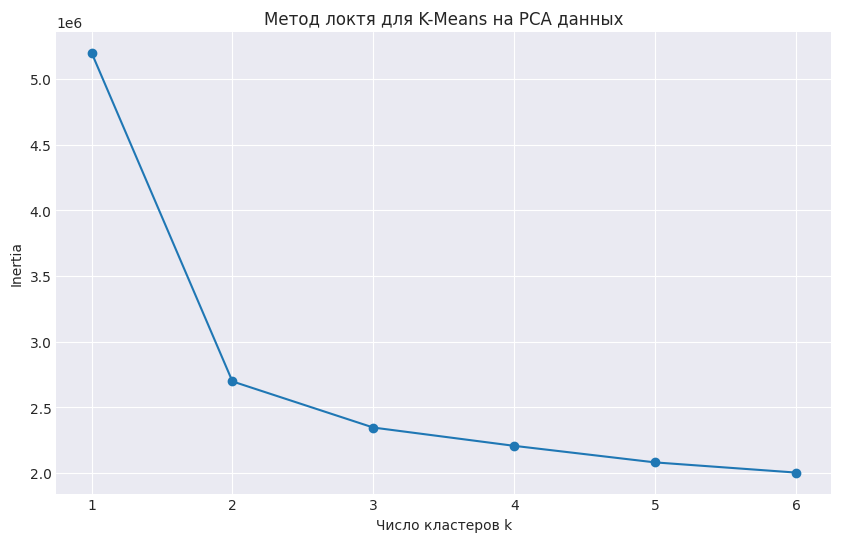

In [15]:
inertia = []
for k in tqdm(range(1, n_classes + 1), desc="Calculating Elbow"):
    km = KMeans(n_clusters=k, n_init=100, random_state=RANDOM_STATE)
    km.fit(X_pca)
    inertia.append(km.inertia_) 

plt.figure(figsize=(10, 6))
plt.plot(range(1, n_classes + 1), inertia, marker='o')
plt.xlabel("Число кластеров k")
plt.ylabel("Inertia")
plt.title("Метод локтя для K-Means на PCA данных")
plt.grid(True)
plt.show()

**Вопрос 5:** (1 балл)

Какое количество кластеров оптимально выбрать, согласно методу локтя?<br>

**Ответ:**
- 1
- **2**
- 3
- 4

Попробуем еще один метод кластеризации, который описывался в статье – агломеративную кластеризацию.

In [16]:
ag = AgglomerativeClustering(n_clusters=n_classes, linkage='ward').fit(X_pca)

Посчитайте Adjusted Rand Index (`sklearn.metrics`) для получившегося разбиения на кластеры и для `KMeans` с параметрами из задания к 4 вопросу.

In [17]:
ari_agglomerative = metrics.adjusted_rand_score(y, ag.labels_)
ari_kmeans = metrics.adjusted_rand_score(y, cluster_labels)

print(f"\nARI K-Means (Custom): {ari_kmeans:.4f}")
print(f"ARI Agglomerative (Ward): {ari_agglomerative:.4f}")


ARI K-Means (Custom): 0.4198
ARI Agglomerative (Ward): 0.4936


**Вопрос 6:** (1 балл)

Отметьте все верные утверждения.<br>

**Варианты:**
- **Согласно ARI, KMeans справился с кластеризацией хуже, чем Agglomerative Clustering**
- **Для ARI не имеет значения какие именно метки присвоены кластерам, имеет значение только разбиение объектов на кластеры**
- **В случае случайного разбиения на кластеры ARI будет близок к нулю**

Можно заметить, что задача не очень хорошо решается именно как задача кластеризации, если выделять несколько кластеров (> 2). Давайте теперь решим задачу классификации, вспомнив, что данные у нас размечены.  

Для классификации используйте метод опорных векторов – класс `sklearn.svm.LinearSVC`. Мы в курсе отдельно не рассматривали этот алгоритм, но он очень известен, почитать про него можно, например, в материалах Евгения Соколова –  [тут](https://github.com/esokolov/ml-course-msu/blob/master/ML16/lecture-notes/Sem11_linear.pdf).

Настройте для `LinearSVC` гиперпараметр `C` с помощью `GridSearchCV`.

- Обучите новый `StandardScaler` на обучающей выборке (со всеми исходными признаками), прмиените масштабирование к тестовой выборке
- В `GridSearchCV` укажите  cv=3.

In [18]:
X_train_scaled_full = scaler.fit_transform(X_train)  
X_test_scaled_full = scaler.transform(X_test)    

In [19]:
svc_params = {'C': [0.001, 0.01, 0.1, 1, 10], 'max_iter': [10000]}
svc = LinearSVC(random_state=RANDOM_STATE)

In [20]:
print("\n--- Обучение SVC на полных масштабированных данных ---")
grid_full = GridSearchCV(estimator=svc, param_grid=svc_params, cv=3, n_jobs=-1)
grid_full.fit(X_train_scaled_full, y_train)
best_svc_full = grid_full.best_estimator_
best_score_full = grid_full.best_score_
print(f"Лучшая C: {best_svc_full.C}, Лучшая CV-оценка: {best_score_full:.4f}")


--- Обучение SVC на полных масштабированных данных ---
Лучшая C: 0.1, Лучшая CV-оценка: 0.9381


**Вопрос 7** (0.5 баллов)

Какое значение гиперпараметра `C` было выбрано лучшим по итогам кросс-валидации?<br>

**Ответ:**
- 0.001
- 0.01
- **0.1**
- 1
- 10

In [21]:
y_predicted_full = best_svc_full.predict(X_test_scaled_full)
print("\nМатрица ошибок (Полные данные) на тестовом наборе:")


Матрица ошибок (Полные данные) на тестовом наборе:


In [22]:
tab_full = pd.crosstab(y_test, y_predicted_full, margins=True)
tab_full.index = ['ходьба', 'подъем вверх по лестнице', 'спуск по лестнице', 'сидение', 'стояние', 'лежание', 'все']
tab_full.columns = ['ходьба', 'подъем вверх по лестнице', 'спуск по лестнице', 'сидение', 'стояние', 'лежание', 'все']
print(tab_full)

                          ходьба  подъем вверх по лестнице  спуск по лестнице  \
ходьба                       494                         2                  0   
подъем вверх по лестнице      12                       459                  0   
спуск по лестнице              2                         4                413   
сидение                        0                         4                  0   
стояние                        0                         0                  0   
лежание                        0                         0                  0   
все                          508                       469                413   

                          сидение  стояние  лежание   все  
ходьба                          0        0        0   496  
подъем вверх по лестнице        0        0        0   471  
спуск по лестнице               1        0        0   420  
сидение                       427       60        0   491  
стояние                        15      517        0

**Вопрос 8:** (0.5 балл)

Какой вид активности SVM определяет хуже всего в терминах точности? Полноты? <br>

**Ответ:**
- по точности – подъем вверх по лестнице, по полноте – лежание
- по точности – лежание, по полноте – сидение
- по точности – ходьба, по полноте – ходьба
- **по точности – сидение, по полноте – стояние**

Наконец, проделайте то же самое, что в 7 вопросе, только добавив PCA.

- Используйте выборки `X_train_scaled` и `X_test_scaled`
- Обучите тот же PCA, что раньше, на отмасшабированной обучающей выборке, примените преобразование к тестовой
- Настройте гиперпараметр `C` на кросс-валидации по обучающей выборке с PCA-преобразованием. Вы заметите, насколько это проходит быстрее, чем раньше.

**Вопрос 9:** (1 балл)

Какова разность между лучшим качеством (долей верных ответов) на кросс-валидации в случае всех 561 исходных признаков и во втором случае, когда применялся метод главных компонент? Округлите до целых процентов.<br>

**Варианты:**
- Качество одинаковое
- 2%
- **4%**
- 10%
- 20%

In [23]:
print("\n--- Обучение SVC на PCA-сжатых данных (0.90) ---")
pca_for_svc = PCA(n_components=0.90, random_state=RANDOM_STATE)
X_train_pca_svc = pca_for_svc.fit_transform(X_train_scaled_full)
X_test_pca_svc = pca_for_svc.transform(X_test_scaled_full)

grid_pca = GridSearchCV(estimator=svc, param_grid=svc_params, cv=3, n_jobs=-1)
grid_pca.fit(X_train_pca_svc, y_train)
best_svc_pca = grid_pca.best_estimator_
best_score_pca = grid_pca.best_score_
print(f"Лучшая C: {best_svc_pca.C}, Лучшая CV-оценка: {best_score_pca:.4f}")

diff = abs(best_score_full - best_score_pca)
print(f"\nРазница в CV-оценках (Полный - PCA): {diff:.4f}")


--- Обучение SVC на PCA-сжатых данных (0.90) ---
Лучшая C: 0.1, Лучшая CV-оценка: 0.8984

Разница в CV-оценках (Полный - PCA): 0.0397


**Вопрос 10:** (1 балл)

Выберите все верные утверждения:

**Варианты:**
- Метод главных компонент в данном случае позволил уменьшить время обучения модели, при этом качество (доля верных ответов на кросс-валидации) очень пострадало, более чем на 10%
- **PCA можно использовать для визуализации данных, однако для этой задачи есть и лучше подходящие методы, например, tSNE. Зато PCA имеет меньшую вычислительную сложность**
- **PCA строит линейные комбинации исходных признаков, и в некоторых задачах они могут плохо интерпретироваться человеком**

**Задание 2.** (1 балл)

Попробуйте использовать DBSCAN в качестве алгоритма кластеризации и метод понижения размерности tSNE.

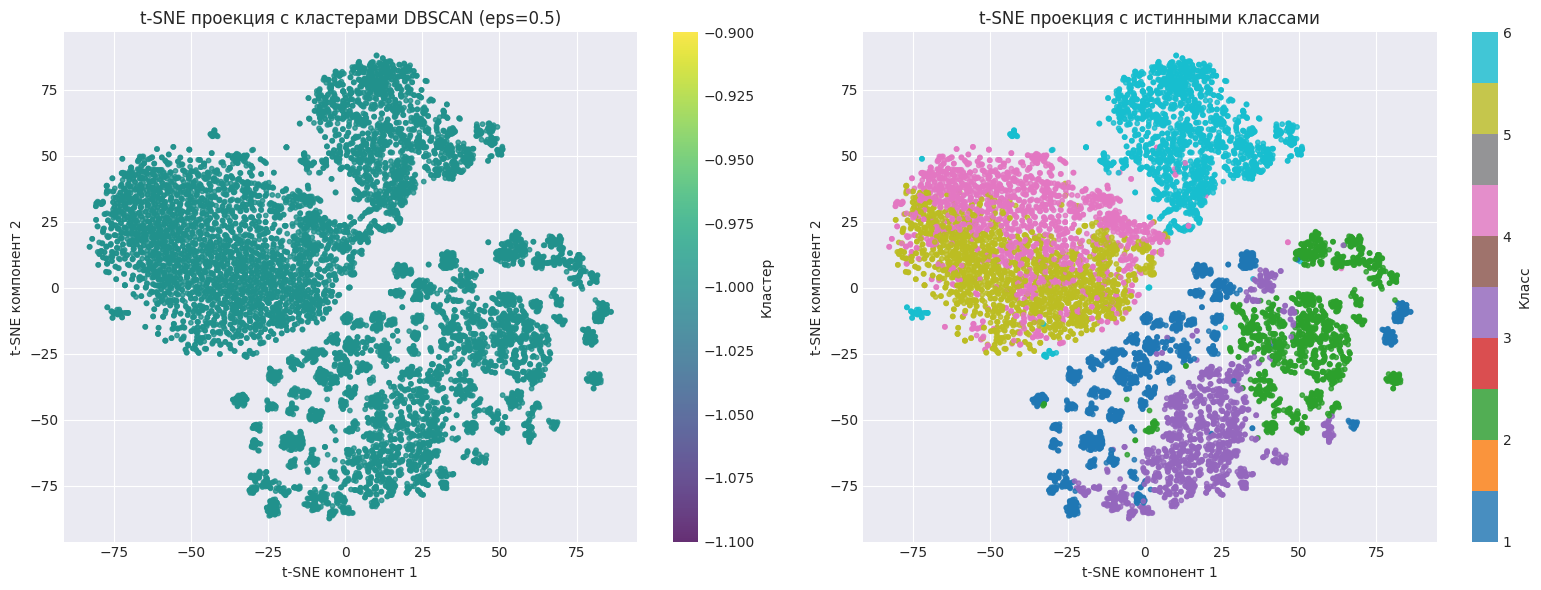


ARI DBSCAN (на PCA данных): 0.0000


In [24]:
tsne = TSNE(
    n_components=2,
    random_state=RANDOM_STATE,
    perplexity=30,       
    learning_rate='auto',
    init='random'
)
X_tsne = tsne.fit_transform(X_pca)

dbscan = DBSCAN(eps=0.5, min_samples=5)
db_labels = dbscan.fit_predict(X_pca)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

scatter1 = axes[0].scatter(X_tsne[:, 0], X_tsne[:, 1], c=db_labels, 
                          cmap='viridis', s=10, alpha=0.8)
axes[0].set_xlabel('t-SNE компонент 1')
axes[0].set_ylabel('t-SNE компонент 2')
axes[0].set_title('t-SNE проекция с кластерами DBSCAN (eps=0.5)')
plt.colorbar(scatter1, ax=axes[0], label='Кластер')

scatter2 = axes[1].scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, 
                          cmap='tab10', s=10, alpha=0.8)
axes[1].set_xlabel('t-SNE компонент 1')
axes[1].set_ylabel('t-SNE компонент 2')
axes[1].set_title('t-SNE проекция с истинными классами')
plt.colorbar(scatter2, ax=axes[1], label='Класс')

plt.tight_layout()
plt.show()

ari_dbscan_pca = metrics.adjusted_rand_score(y, db_labels)
print(f"\nARI DBSCAN (на PCA данных): {ari_dbscan_pca:.4f}")
